# Klasifikasi Gambar Gesture Tangan Kertas Batu Gunting

Melakukunan *import* modul yang diperlukuan untuk membuat model *machine learning*

In [0]:
#import modul yang diperlukan
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import decode_predictions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os

print(tf.__version__)


2.2.0


Mengunduh dataset dari *repository* Github pribadi. Dataset yang diunduh merupakan hasil modifikasi dari dataset yang bersumber dari situs [dicoding.com](https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip) dengan menghapus *folder* **_MACOSX** dan menghapus folder **rps_cv_images** karena merupakan duplikat dari folder utama, sehingga ukuran file lebih kecil 50% dari file aslinya

In [0]:
!wget --no-check-certificate \
  https://github.com/teguhdarajat/dataset_kertasbatugunting/raw/master/kertasbatugunting.zip \
  -O /tmp/kertasbatugunting.zip

--2020-05-17 11:15:27--  https://github.com/teguhdarajat/dataset_kertasbatugunting/raw/master/kertasbatugunting.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/teguhdarajat/dataset_kertasbatugunting/master/kertasbatugunting.zip [following]
--2020-05-17 11:15:27--  https://media.githubusercontent.com/media/teguhdarajat/dataset_kertasbatugunting/master/kertasbatugunting.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159752418 (152M) [application/zip]
Saving to: ‘/tmp/kertasbatugunting.zip’

/tmp/kertasbatugunt 100%[===================>] 152.35M   109MB/s    in 1.4s    

2020-05

In [0]:
#mengekstra file di folder /temp
local_zip = '/tmp/kertasbatugunting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#menampilkan list file yang terdapat pada direktori rockpaperscissors
os.listdir('/tmp/rockpaperscissors')

['paper', 'scissors', 'rock', 'README_rpc-cv-images.txt']

In [0]:
base_dir = '/tmp/rockpaperscissors'

papers_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')
rocks_dir = os.path.join(base_dir, 'rock')

papers_count = len(os.listdir(paper_dir))
scissors_count = len(os.listdir(scissors_dir))
rocks_count = len(os.listdir(rock_dir))

print("Ditemukan sebanyak", papers_count, "buah gambar kertas")
print("Ditemukan sebanyak", scissors_count, "buah gambar gunting")
print("Ditemukan sebanyak", rocks_count, "buah gambar batu")

Ditemukan sebanyak 712 buah gambar kertas
Ditemukan sebanyak 750 buah gambar gunting
Ditemukan sebanyak 726 buah gambar batu


In [0]:
#Membuat image augmentation dengan ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    #menyisihikan 15% data sebagai validation data
    validation_split=0.15)

In [0]:
#data latih
train_generator = datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical',
        subset='training')

#data validasi
validation_generator = datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical',
        subset='validation')

#melihat class
labels = validation_generator.class_indices
labels

Found 1862 images belonging to 3 classes.
Found 326 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

In [0]:
first_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),   
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    #hidden layer 1
    tf.keras.layers.Dense(512, activation='relu'),
    
    #hidden layer 2
    tf.keras.layers.Dense(256, activation='relu'),

    #output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

first_model.summary()

#menggunakan loss function categorical_crossentropy dan optimizer adam
first_model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

first_model_history = first_model.fit(train_generator, epochs=50, steps_per_epoch=25, validation_data=validation_generator, verbose=1, validation_steps=3)

first_model.save('first_model.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [0]:
second_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),   
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    #hidden layer 1
    tf.keras.layers.Dense(512, activation='relu'),

    #output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

second_model.summary()

#menggunakan loss function sparse_categorical_crossentropy dan optimizer rmsprop
second_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

second_model_history = first_model.fit(train_generator, epochs=50, steps_per_epoch=25, validation_data=validation_generator, verbose=1, validation_steps=3)

second_model.save('second_model.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 36992)            

In [0]:
labels = validation_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

Saving 20200517_153739.jpg to 20200517_153739.jpg
20200517_153739.jpg
Hasil prediksi model pertama: "scissor"
Hasil prediksi model kedua: "paper"


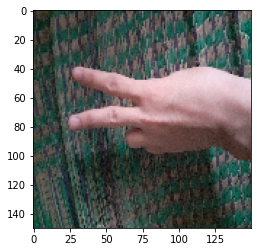

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  first_model_prediction = first_model.predict_classes(images, batch_size=10)
  second_model_prediction = second_model.predict_classes(images, batch_size=10)
  
  print(fn)
  if(first_model_prediction == 0):
    print('Hasil prediksi model pertama: "paper"')
  elif(first_model_prediction == 1):
    print('Hasil prediksi model pertama: "rock"')
  elif(first_model_prediction == 2):
    print('Hasil prediksi model pertama: "scissor"')
  
  if(second_model_prediction == 0):
    print('Hasil prediksi model kedua: "paper"')
  elif(second_model_prediction == 1):
    print('Hasil prediksi model kedua: "rock"')
  elif(second_model_prediction == 2):
    print('Hasil prediksi model kedua: "scissor"')

## Plot Akurasi

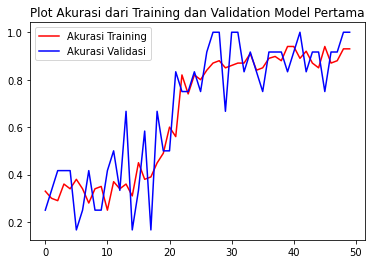

<Figure size 432x288 with 0 Axes>

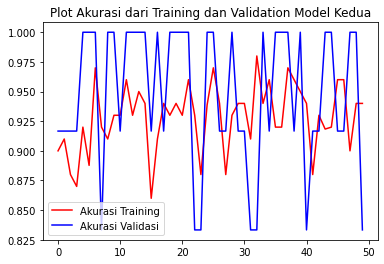

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

#Model Pertama
first_model_accuracy = first_model_history.history['accuracy']
first_model_val_accuracy = first_model_history.history['val_accuracy']
first_model_loss = first_model_history.history['loss']
first_model_val_loss = first_model_history.history['val_loss']
first_model_epochs = range(len(first_model_accuracy))

#Model Kedua
second_model_accuracy = second_model_history.history['accuracy']
second_model_val_accuracy = second_model_history.history['val_accuracy']
second_model_loss = second_model_history.history['loss']
second_model_val_loss = second_model_history.history['val_loss']
second_model_epochs = range(len(second_model_accuracy))

#Plot Model Pertama
plt.plot(first_model_epochs, first_model_accuracy, 'r', label='Akurasi Training')
plt.plot(first_model_epochs, first_model_val_accuracy, 'b', label='Akurasi Validasi')
plt.title('Plot Akurasi dari Training dan Validation Model Pertama')
plt.legend(loc=0)
plt.figure()
plt.show()

#Plot Model Kedua
plt.plot(second_model_epochs, second_model_accuracy, 'r', label='Akurasi Training')
plt.plot(second_model_epochs, second_model_val_accuracy, 'b', label='Akurasi Validasi')
plt.title('Plot Akurasi dari Training dan Validation Model Kedua')
plt.legend(loc=0)
plt.figure()
plt.show()